In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,  cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df = pd.read_csv('train.csv')

In [3]:
#Clean data
#remove unnecessary columns that are not relevant to the data
#Removing PassengerId, Name, Ticket, Cabin
df = df.drop(columns=['PassengerId','Name','Ticket','Cabin'])
#removing rows with empty columns
df = df.dropna()
#Change estimated age to age (drop .5)
df['Age'] =  df['Age'].astype(int)
print(df.head())
print(len(df))

   Survived  Pclass     Sex  Age  SibSp  Parch     Fare Embarked
0         0       3    male   22      1      0   7.2500        S
1         1       1  female   38      1      0  71.2833        C
2         1       3  female   26      0      0   7.9250        S
3         1       1  female   35      1      0  53.1000        S
4         0       3    male   35      0      0   8.0500        S
712


In [4]:
#Use IQR method to remove outliers
#selecting columns to remove outliers for relevant columns using IQR method (used 2.5 iqr insread of 1.5 as it seems to remove too much)
remove_outlier_columns = ['Age','SibSp','Parch','Fare']
q1 = df[remove_outlier_columns].quantile(0.25)
q3 = df[remove_outlier_columns].quantile(0.75)

iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
for column in remove_outlier_columns:
    df = df[(df[column] >= lower_bound[column]) & (df[column] <= upper_bound[column])]
print(df.head())
print(len(df))

# Find the number of passangers that survived and not survived
total_survived = df[df['Survived'] == 1]['Survived'].count()
total_not_survived = df[df['Survived'] == 0]['Survived'].count()

print(f'survived: {total_survived}')
print(f'not survived: {total_not_survived}')

   Survived  Pclass     Sex  Age  SibSp  Parch     Fare Embarked
0         0       3    male   22      1      0   7.2500        S
2         1       3  female   26      0      0   7.9250        S
3         1       1  female   35      1      0  53.1000        S
4         0       3    male   35      0      0   8.0500        S
6         0       1    male   54      0      0  51.8625        S
564
survived: 210
not survived: 354


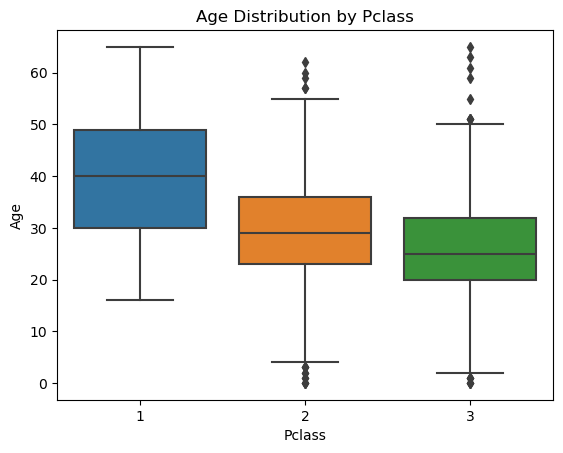

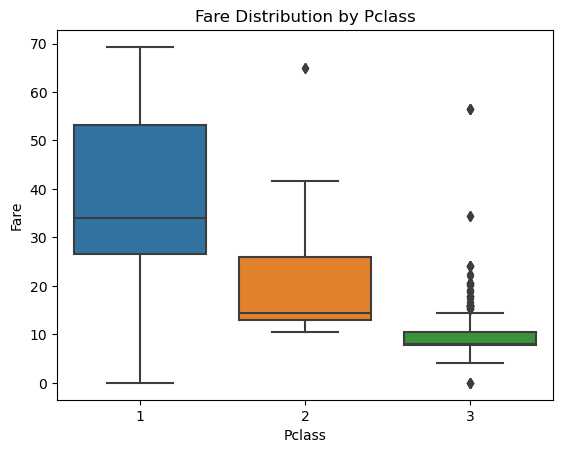

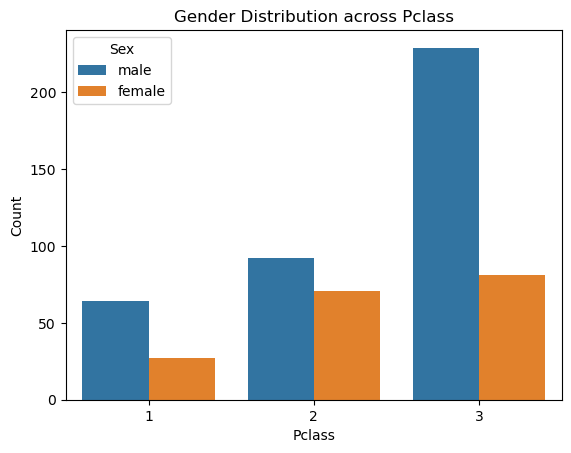

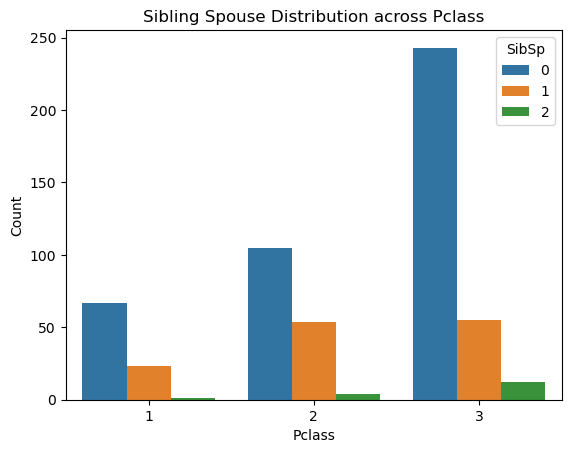

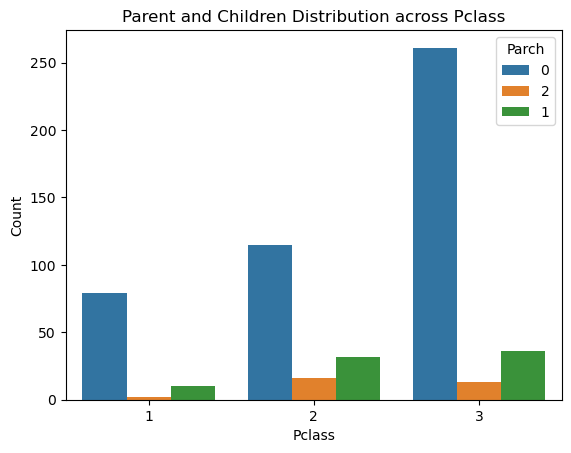

In [5]:
#Show graphs Socioeconomic status of various features
sns.boxplot(x='Pclass', y='Age', data=df)
plt.title('Age Distribution by Pclass')
plt.xlabel('Pclass')
plt.ylabel('Age')
plt.show()


sns.boxplot(x='Pclass', y='Fare', data=df)
plt.title('Fare Distribution by Pclass')
plt.xlabel('Pclass')
plt.ylabel('Fare')
plt.show()

df_temp = df
df_temp['Sex'] = df_temp['Sex'].astype(str)
sns.countplot(x='Pclass', hue='Sex', data=df_temp)
plt.title('Gender Distribution across Pclass')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.show()

df_temp['SibSp'] = df_temp['SibSp'].astype(str)
sns.countplot(x='Pclass', hue='SibSp', data=df_temp, hue_order=sorted(df_temp['SibSp'].unique(), key=int))
plt.title('Sibling Spouse Distribution across Pclass')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.show()

df_temp['Parch'] = df_temp['Parch'].astype(str)
sns.countplot(x='Pclass', hue='Parch', data=df_temp)
plt.title('Parent and Children Distribution across Pclass')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.show()

   Survived  Pclass Sex  Age SibSp Parch     Fare Embarked
0         0       3   0   22     1     0   7.2500        0
2         1       3   1   26     0     0   7.9250        0
3         1       1   1   35     1     0  53.1000        0
4         0       3   0   35     0     0   8.0500        0
6         0       1   0   54     0     0  51.8625        0


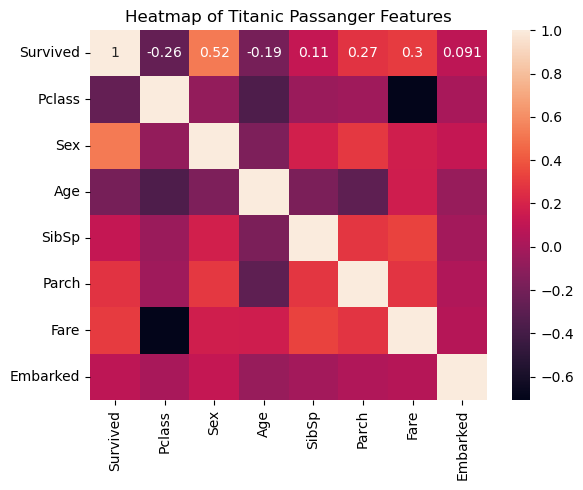

In [6]:
#Exploring socia economic status of passengers
#Heatmap is not being displayed correctly and I therefore included a image file of the heatmap
#Change Sex: Male to 0 and Female to 1
df.loc[df["Sex"] == "male", "Sex"] = 0
df.loc[df["Sex"] == "female", "Sex"] = 1
#Change Embarked: S to 0 and C to 1 and Q to 2
df.loc[df["Embarked"] == "S", "Embarked"] = 0
df.loc[df["Embarked"] == "C", "Embarked"] = 1
df.loc[df["Embarked"] == "Q", "Embarked"] = 2
correlation_matrix = df.corr()
print(df.head())
sns.heatmap(df.corr(), annot=True)
plt.title('Heatmap of Titanic Passanger Features')
plt.show()

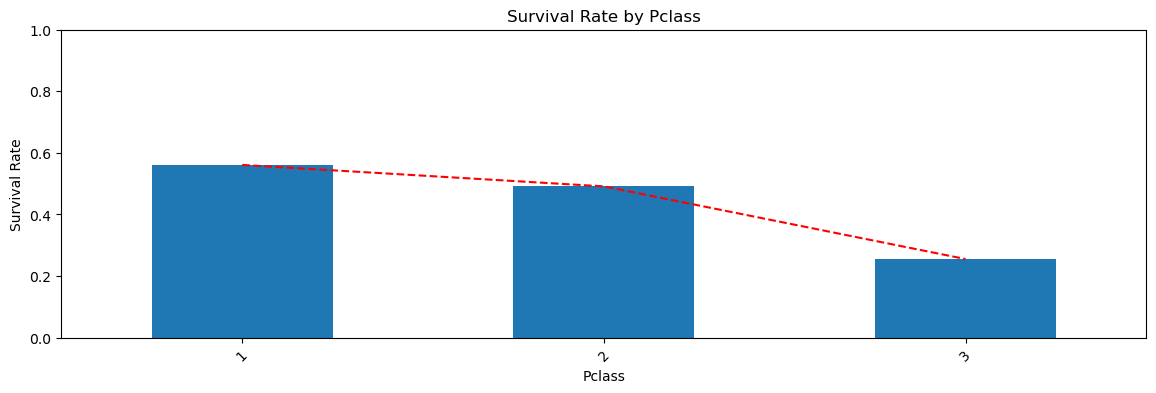

C:\Users\joshu\AppData\Local\Temp\ipykernel_27080\348377464.py:16: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x, y, 2)


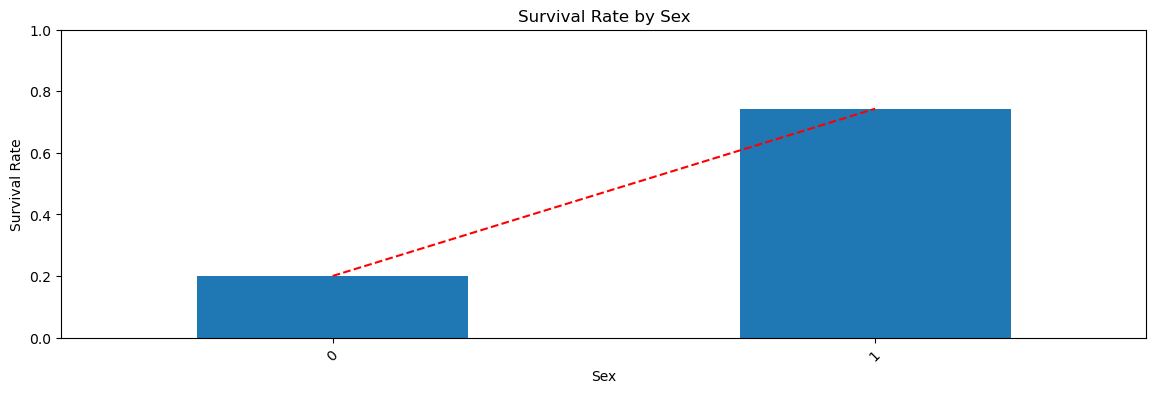

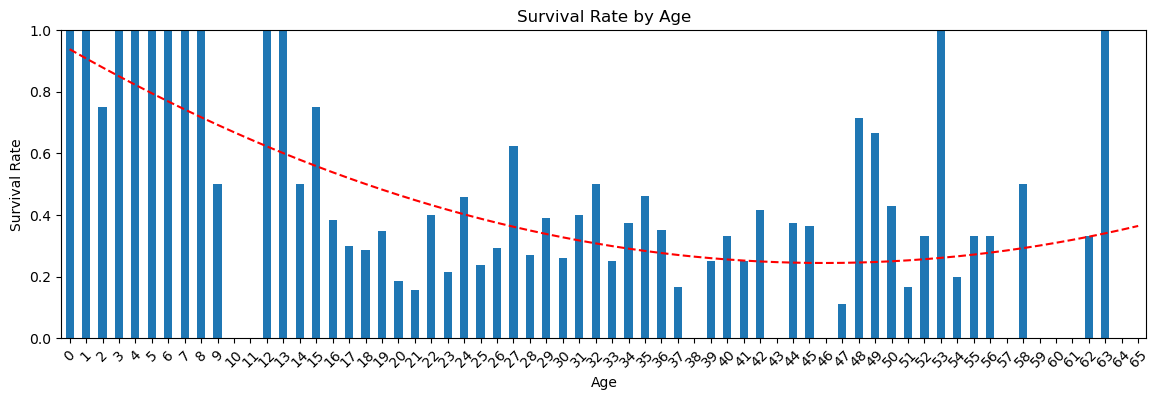

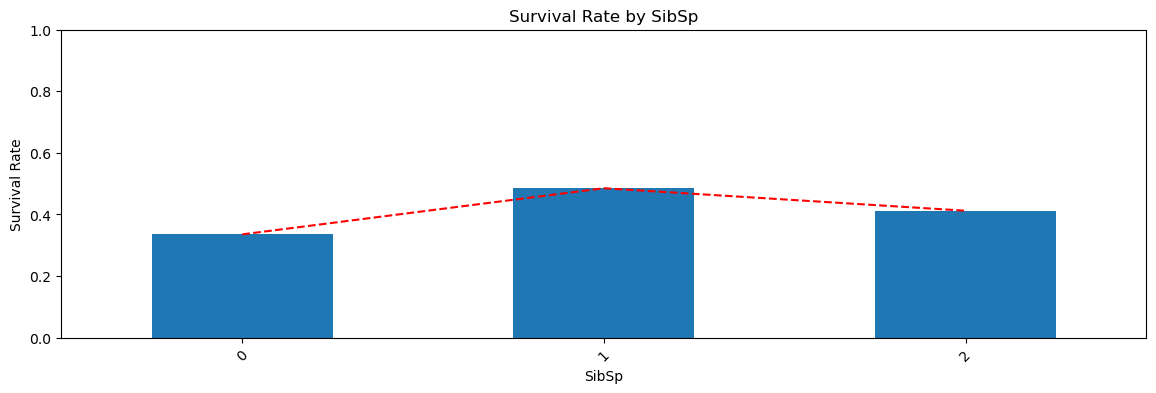

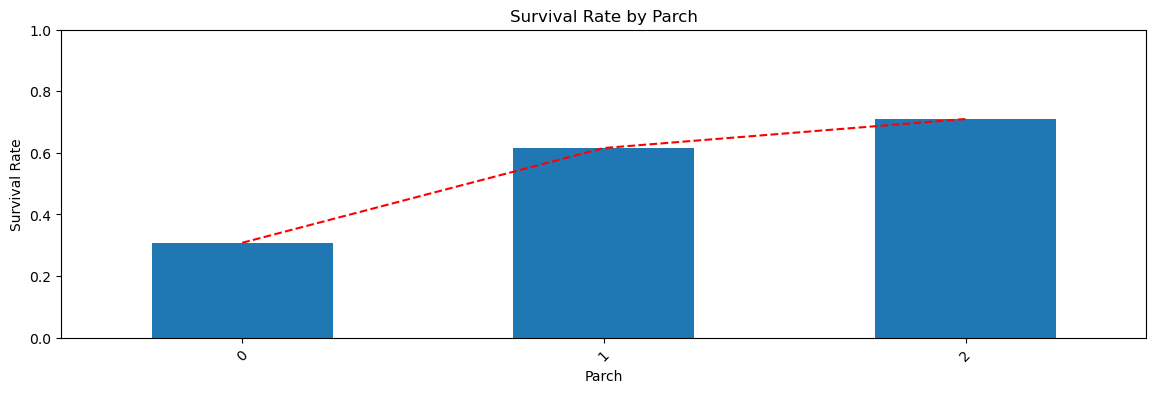

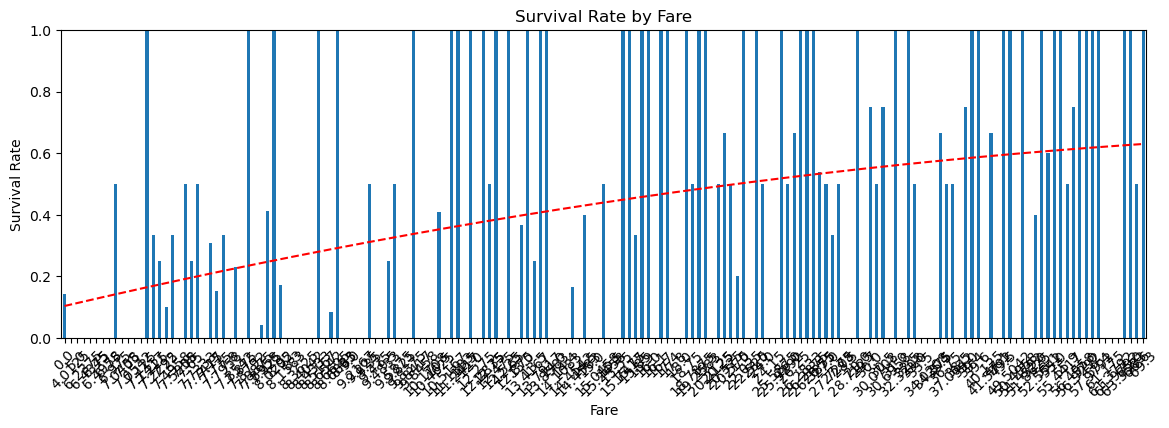

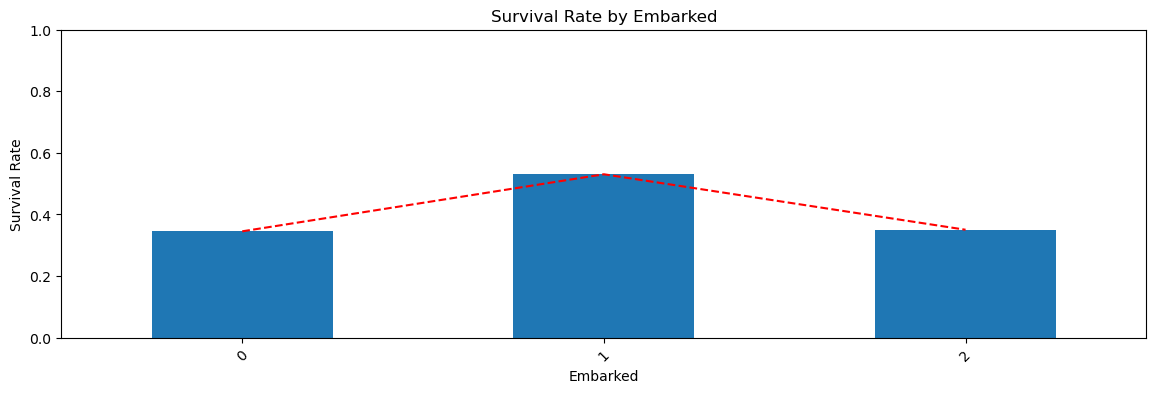

In [7]:
#Survival rates for different features
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
  
for feature in features:
    #calculate survival rate for feature
    survival_rate = df.groupby(feature)['Survived'].mean()
    
    #Plot the survival rate
    plt.figure(figsize=(14, 4))
    survival_rate.plot(kind='bar')
    
    x = np.arange(len(survival_rate))
    y = survival_rate.values
    
    #Add trendline
    z = np.polyfit(x, y, 2)  
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--") 

    #configure plot
    plt.title(f'Survival Rate by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Survival Rate')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.show()

In [8]:
#Prepare data
from imblearn.over_sampling import RandomOverSampler

x = df.drop(columns=['Survived'])
y = df['Survived']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1,random_state=1)

In [9]:
#Use Linear Regression to predict survivability but no polynomial fitting just used as a performance comparision with model below

#Use Random OverSampling
ros = RandomOverSampler(random_state=1)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Build and train the Linear Regression model
model = LinearRegression()
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)
y_pred_binary = np.where(y_pred >= 0.5, 1, 0)

# Evaluate performance of the model
accuracy = accuracy_score(y_test, y_pred_binary) * 100
precision = precision_score(y_test, y_pred_binary) * 100
recall = recall_score(y_test, y_pred_binary) * 100
f1 = f1_score(y_test, y_pred_binary) * 100

print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.2f}%')
print(f'Recall: {recall:.2f}%')
print(f'F1 Score: {f1:.2f}%')

y_pred_cv = cross_val_predict(model, x, y, cv=5)
y_pred_cv_binary = np.where(y_pred_cv >= 0.5, 1, 0)

#Perform cross validation
cv_accuracy = accuracy_score(y, y_pred_cv_binary) * 100
cv_precision = precision_score(y, y_pred_cv_binary) * 100
cv_recall = recall_score(y, y_pred_cv_binary) * 100
cv_f1 = f1_score(y, y_pred_cv_binary) * 100

print(f'\nCross-Validation Accuracy: {cv_accuracy:.2f}%')
print(f'Cross-Validation Precision: {cv_precision:.2f}%')
print(f'Cross-Validation Recall: {cv_recall:.2f}%')
print(f'Cross-Validation F1 Score: {cv_f1:.2f}%')

Accuracy: 84.21%
Precision: 82.35%
Recall: 70.00%
F1 Score: 75.68%

Cross-Validation Accuracy: 78.72%
Cross-Validation Precision: 73.44%
Cross-Validation Recall: 67.14%
Cross-Validation F1 Score: 70.15%


In [10]:
# Build and train the Linear Regression model but age is fitted as polynomial
from sklearn.preprocessing import PolynomialFeatures

df_poly = df.copy()

#Use Age^2 to fit data
poly = PolynomialFeatures(degree=2, include_bias=False)
df_age_poly = poly.fit_transform(df[['Age']]) 
poly_features = poly.get_feature_names_out(['Age'])
df_age_poly = pd.DataFrame(df_age_poly, columns=poly_features)

df_poly = pd.concat([df_poly, df_age_poly], axis=1)
df_poly = df_poly.drop(columns=['Age'])

df_poly = df_poly.dropna()

print(df_poly.head())

#Prepare data for training
x_poly = df_poly.drop(columns=['Survived'])
y_poly = df_poly['Survived']

X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(x_poly, y_poly, test_size=0.1, random_state=1)

#Linear Regression
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train_poly)

# Performance Evaulation
y_pred_poly = model_poly.predict(X_test_poly)
y_pred_binary_poly = np.where(y_pred_poly >= 0.5, 1, 0)

accuracy_poly = accuracy_score(y_test_poly, y_pred_binary_poly) * 100
precision_poly = precision_score(y_test_poly, y_pred_binary_poly) * 100
recall_poly = recall_score(y_test_poly, y_pred_binary_poly) * 100
f1_poly = f1_score(y_test_poly, y_pred_binary_poly) * 100

print(f'Polynomial Regression Accuracy: {accuracy_poly:.2f}%')
print(f'Polynomial Regression Precision: {precision_poly:.2f}%')
print(f'Polynomial Regression Recall: {recall_poly:.2f}%')
print(f'Polynomial Regression F1 Score: {f1_poly:.2f}%')

# Performance Evaulation in cross validation
y_pred_cv_poly = cross_val_predict(model_poly, x_poly, y_poly, cv=5)
y_pred_cv_binary_poly = np.where(y_pred_cv_poly >= 0.5, 1, 0)

cv_accuracy_poly = accuracy_score(y_poly, y_pred_cv_binary_poly) * 100
cv_precision_poly = precision_score(y_poly, y_pred_cv_binary_poly) * 100
cv_recall_poly = recall_score(y_poly, y_pred_cv_binary_poly) * 100
cv_f1_poly = f1_score(y_poly, y_pred_cv_binary_poly) * 100

print(f'\nPolynomial Regression Cross-Validation Accuracy: {cv_accuracy_poly:.2f}%')
print(f'Polynomial Regression Cross-Validation Precision: {cv_precision_poly:.2f}%')
print(f'Polynomial Regression Cross-Validation Recall: {cv_recall_poly:.2f}%')
print(f'Polynomial Regression Cross-Validation F1 Score: {cv_f1_poly:.2f}%')

   Survived  Pclass Sex SibSp Parch     Fare Embarked   Age^2
0       0.0     3.0   0     1     0   7.2500        0   484.0
2       1.0     3.0   1     0     0   7.9250        0  1225.0
3       1.0     1.0   1     1     0  53.1000        0  1225.0
4       0.0     3.0   0     0     0   8.0500        0  2916.0
6       0.0     1.0   0     0     0  51.8625        0   196.0
Polynomial Regression Accuracy: 77.78%
Polynomial Regression Precision: 77.78%
Polynomial Regression Recall: 77.78%
Polynomial Regression F1 Score: 77.78%

Polynomial Regression Cross-Validation Accuracy: 77.56%
Polynomial Regression Cross-Validation Precision: 72.36%
Polynomial Regression Cross-Validation Recall: 66.42%
Polynomial Regression Cross-Validation F1 Score: 69.26%


In [11]:
# Compare performance of model with and without cross validation
df_poly = df.copy()

# Transform Age into polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
df_age_poly = poly.fit_transform(df[['Age']])
poly_features = poly.get_feature_names_out(['Age'])
df_age_poly = pd.DataFrame(df_age_poly, columns=poly_features)

# remove age and include age^2
df_poly = pd.concat([df_poly, df_age_poly], axis=1)
df_poly = df_poly.drop(columns=['Age'])

# Drop rows with any missing values
df_poly = df_poly.dropna()

x_poly = df_poly.drop(columns=['Survived'])
y_poly = df_poly['Survived']

# Initialize totals
total_f1_score = 0
total_cv_f1_score = 0

# Iterate over different random states
for random_state in range(1, 51):
    X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(x_poly, y_poly, test_size=0.1, random_state=random_state)

    # train Linear Regression model with polynomial features
    model_poly = LinearRegression()
    model_poly.fit(X_train_poly, y_train_poly)

    y_pred_poly = model_poly.predict(X_test_poly)
    y_pred_binary_poly = np.where(y_pred_poly >= 0.5, 1, 0)

    # Evaluate model
    f1_poly = f1_score(y_test_poly, y_pred_binary_poly) * 100
    total_f1_score += f1_poly

    # Perform cross-validation
    y_pred_cv_poly = cross_val_predict(model_poly, x_poly, y_poly, cv=5)
    y_pred_cv_binary_poly = np.where(y_pred_cv_poly >= 0.5, 1, 0)

    # Evaluate cross validation 
    cv_f1_poly = f1_score(y_poly, y_pred_cv_binary_poly) * 100
    total_cv_f1_score += cv_f1_poly

# Calculate averages
average_f1_score = total_f1_score / 50
average_cv_f1_score = total_cv_f1_score / 50

#Results
print(f'Average F1 Score: {average_f1_score:.2f}%')
print(f'Average Cross-Validation F1 Score: {average_cv_f1_score:.2f}%')

if average_f1_score > average_cv_f1_score:
    print("F1 Score on test set is higher.")
else:
    print("Cross-Validation F1 Score is higher.")
print(f'Average difference is {abs(average_f1_score - average_cv_f1_score):.2f}%')

Average F1 Score: 68.20%
Average Cross-Validation F1 Score: 69.26%
Cross-Validation F1 Score is higher.
Average difference is 1.06%


In [12]:
#Use K-Nearest Neighbor Classifier model to predict survival
from sklearn.neighbors import KNeighborsClassifier

x = df.drop(columns=['Survived'])
y = df['Survived']

ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(x, y)

#Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=1)

#train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)


y_pred = knn_model.predict(X_test)

#Evaluate model
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100

print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.2f}%')
print(f'Recall: {recall:.2f}%')
print(f'F1 Score: {f1:.2f}%\n')

#Evaluate cross-validation
y_pred_cv = cross_val_predict(knn_model, X_resampled, y_resampled, cv=5)
cv_accuracy = accuracy_score(y_resampled, y_pred_cv) * 100
cv_precision = precision_score(y_resampled, y_pred_cv) * 100
cv_recall = recall_score(y_resampled, y_pred_cv) * 100
cv_f1 = f1_score(y_resampled, y_pred_cv) * 100

print(f'\nCross-Validation Accuracy: {cv_accuracy:.2f}%')
print(f'Cross-Validation Precision: {cv_precision:.2f}%')
print(f'Cross-Validation Recall: {cv_recall:.2f}%')
print(f'Cross-Validation F1 Score: {cv_f1:.2f}%')

Accuracy: 66.20%
Precision: 58.97%
Recall: 74.19%
F1 Score: 65.71%


Cross-Validation Accuracy: 67.23%
Cross-Validation Precision: 66.67%
Cross-Validation Recall: 68.93%
Cross-Validation F1 Score: 67.78%


In [13]:
# Compare performance of model with and without cross validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler


def evaluate_model_with_random_states(df, random_states):
    f1_scores = []
    cv_f1_scores = []

    for state in random_states:
        x = df.drop(columns=['Survived'])
        y = df['Survived']

        ros = RandomOverSampler(random_state=state)
        X_resampled, y_resampled = ros.fit_resample(x, y)

        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=state)

        #train the KNN model
        knn_model = KNeighborsClassifier(n_neighbors=5)
        knn_model.fit(X_train, y_train)

        
        y_pred = knn_model.predict(X_test)

        # Evaluate model
        f1 = f1_score(y_test, y_pred) * 100
        f1_scores.append(f1)

        #Evaluate cross-validation
        y_pred_cv = cross_val_predict(knn_model, X_resampled, y_resampled, cv=5)
        cv_f1 = f1_score(y_resampled, y_pred_cv) * 100
        cv_f1_scores.append(cv_f1)

    total_f1_score = sum(f1_scores)
    total_cv_f1_score = sum(cv_f1_scores)

    return total_f1_score, total_cv_f1_score

#Iterate over random states
random_states = range(1, 51)
total_f1_score, total_cv_f1_score = evaluate_model_with_random_states(df, random_states)

average_f1_score = total_f1_score / 50
average_cv_f1_score = total_cv_f1_score / 50

#Results
print(f'Average F1 Score: {average_f1_score:.2f}%')
print(f'Average Cross-Validation F1 Score: {average_cv_f1_score:.2f}%')

if total_f1_score > total_cv_f1_score:
    print("F1 Score on test set is higher.")
else:
    print("Cross-Validation F1 Score is higher.")
print(f'Average difference is {abs(average_f1_score - average_cv_f1_score):.2f}%')

Average F1 Score: 70.93%
Average Cross-Validation F1 Score: 70.16%
F1 Score on test set is higher.
Average difference is 0.77%


In [14]:
#Use Logistic Regression Classifier model to predict survival
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100

print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.2f}%')
print(f'Recall: {recall:.2f}%')
print(f'F1 Score: {f1:.2f}%')

#Evaluate cross-validation
y_pred_cv = cross_val_predict(logistic_model, x, y, cv=5)
cv_accuracy = accuracy_score(y, y_pred_cv) * 100
cv_precision = precision_score(y, y_pred_cv) * 100
cv_recall = recall_score(y, y_pred_cv) * 100
cv_f1 = f1_score(y, y_pred_cv) * 100

print(f'\nCross-Validation Accuracy: {cv_accuracy:.2f}%')
print(f'Cross-Validation Precision: {cv_precision:.2f}%')
print(f'Cross-Validation Recall: {cv_recall:.2f}%')
print(f'Cross-Validation F1 Score: {cv_f1:.2f}%')

Accuracy: 80.28%
Precision: 74.29%
Recall: 83.87%
F1 Score: 78.79%

Cross-Validation Accuracy: 78.90%
Cross-Validation Precision: 73.10%
Cross-Validation Recall: 68.57%
Cross-Validation F1 Score: 70.76%


In [15]:
# Compare performance of model with and without cross validation

total_f1_score = 0
total_cv_f1_score = 0

# Iterate over different random states
for random_state in range(1, 51):
    x = df.drop(columns=['Survived'])
    y = df['Survived']

    # Oversample 
    ros = RandomOverSampler(random_state=random_state)
    X_resampled, y_resampled = ros.fit_resample(x, y)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=random_state)

    logistic_model = LogisticRegression(max_iter=1000)
    logistic_model.fit(X_train, y_train)

    y_pred = logistic_model.predict(X_test)
    y_pred_binary = np.where(y_pred >= 0.5, 1, 0)

    #Evaluate the model
    f1 = f1_score(y_test, y_pred_binary) * 100
    total_f1_score += f1

    # Evaluate cross-validation
    y_pred_cv = cross_val_predict(logistic_model, X_resampled, y_resampled, cv=5)
    y_pred_cv_binary = np.where(y_pred_cv >= 0.5, 1, 0)

    cv_f1 = f1_score(y_resampled, y_pred_cv_binary) * 100
    total_cv_f1_score += cv_f1

# Calculate averages
average_f1_score = total_f1_score / 50
average_cv_f1_score = total_cv_f1_score / 50

#Results
print(f'Average F1 Score: {average_f1_score:.2f}%')
print(f'Average Cross-Validation F1 Score: {average_cv_f1_score:.2f}%')

if total_f1_score > total_cv_f1_score:
    print("F1 Score on test set is higher.")
else:
    print("Cross-Validation F1 Score is higher.")
print(f'Average difference is {abs(average_f1_score - average_cv_f1_score):.2f}%')

Average F1 Score: 78.87%
Average Cross-Validation F1 Score: 78.19%
F1 Score on test set is higher.
Average difference is 0.69%
